In [5]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import plotly.express   as px
import cv2
import plotly.graph_objects as go
import random

I took some code for visualization from this site: https://medium.com/@sehjadkhoja0/title-exploring-and-analyzing-image-data-with-python-79a7f72f4d2b#:~:text=By%20plotting%20the%20sizes%20of,is%20helpful%20for%20subsequent%20analysis. 
The remaining codes belong to me. 


In [1]:
labels = []
images = []

In [3]:
# Walk through the directory to collect image and label files.
   
for dirname, _,filenames in os.walk('sec1/dataset/sec1'): 
    labels = [file for file in filenames if file.endswith(".txt")] # Collect all .txt files as labels.
    images = [file for file in filenames if file.endswith(".png")] # Collect all .png files as images.

In [4]:
print(len(images),len(labels))

4500 4500


In [10]:
sizes = []
resolutions = []
color_distributions = []
root_path = 'sec1/dataset/sec1'

In [6]:
for image in images:
    if image.lower().endswith('.png'):
        img_path = os.path.join(root_path, image)

        # Load the image file using OpenCV
        img = cv2.imread(img_path)
        
        # Extract the size of the image
        size = os.path.getsize(img_path)
        sizes.append(size)
        
        # Extract the resolution of the image
        resolution = img.shape[:2]
        resolutions.append(resolution)

        # Extract the color distribution of the image
        color_distribution = np.bincount(img.flatten(), minlength=256)
        color_distributions.append(color_distribution)

In [7]:
# Convert the lists to numpy arrays for easier manipulation
sizes_np = np.array(sizes)
resolutions_np = np.array(resolutions)
color_distributions_np = np.array(color_distributions)

####  Visualizations to gain insights about the data.

In [8]:
# Create a histogram figure with plotly
fig = px.histogram(x=sizes, nbins=50, title="Distribution of Image Sizes")

# Customize the plot
fig.update_layout(
    xaxis_title="File Size (MB)",
    yaxis_title="Number of Images",
    showlegend=False,
    bargap=0.1,
    bargroupgap=0.1
)

# Show the plot
fig.show()

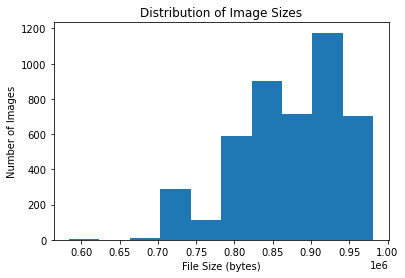

In [9]:
# Plot a histogram of the image sizes
plt.hist(sizes)
plt.title("Distribution of Image Sizes")
plt.xlabel("File Size (bytes)")
plt.ylabel("Number of Images")
plt.show()

In [10]:
# Create a scatter plot figure with plotly
fig = px.scatter(x=resolutions_np[:, 0], y=resolutions_np[:, 1], title="Distribution of Image Resolutions")

# Customize the plot
fig.update_layout(
    xaxis_title="Width (pixels)",
    yaxis_title="Height (pixels)",
    showlegend=False,
    hovermode="closest",
    width=800,
    height=600,
    margin=dict(l=50, r=50, b=50, t=50, pad=4)
)

# Show the plot
fig.show()

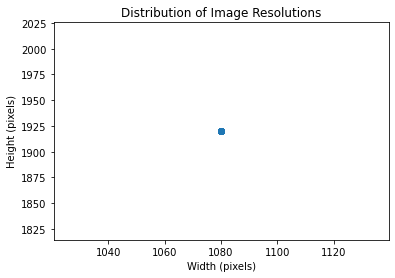

In [11]:

# Plot a scatter plot of the image resolutions
plt.scatter(resolutions_np[:, 0], resolutions_np[:, 1])
plt.title("Distribution of Image Resolutions")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.show()

In [12]:

# Calculate the mean color distribution across all images
mean_color_distribution = np.mean(color_distributions_np, axis=0)

# Create a bar chart of the mean color distribution
fig = go.Figure(
    go.Bar(x=np.arange(256), y=mean_color_distribution, name="Mean Color Distribution")
)

# Set the title and axis labels
fig.update_layout(
    title="Mean Color Distribution",
    xaxis_title="Color Value",
    yaxis_title="Number of Pixels"
)

# Show the plot
fig.show()

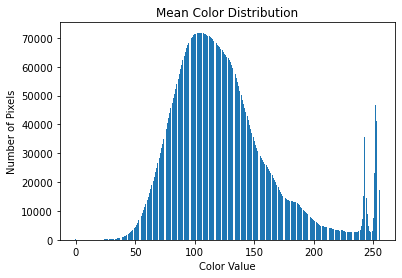

In [13]:
# Calculate the mean color distribution across all images
mean_color_distribution = np.mean(color_distributions, axis=0)

# Plot a bar chart of the mean color distribution
plt.bar(np.arange(256), mean_color_distribution)
plt.title("Mean Color Distribution")
plt.xlabel("Color Value")
plt.ylabel("Number of Pixels")
plt.show()

#### Split the dataset into test and train set based on a split ratio.


In [ ]:

import numpy as np
import os
import shutil
from torch.utils.data.sampler import SubsetRandomSampler

os.chdir("sec1")
a = 0
random_seed = 42
dst_folder = 'testset/'


class_size = len(images)
indices = list(range(class_size))
split_ratio = .2
split = int(np.floor(split_ratio * class_size))
np.random.seed(random_seed)
np.random.shuffle(indices)
test_indices = indices[:split]

# Move files to the testset directory based on the indices.
for i in test_indices:
    image = images[i][:-4]
    shutil.move('dataset/sec1/'+ image  + ".png", dst_folder + image + ".png")
    shutil.move('dataset/sec1/'+ image  + ".txt", dst_folder + image + ".txt")




### Vehicle Extraction

In [3]:
labels_train = []
images_train = []

In [6]:
# Walk through the directory to collect image and label files.
   
for dirname, _,filenames in os.walk('sec1/dataset/sec1'): 
    labels_train = [file for file in filenames if file.endswith(".txt")] # Collect all .txt files as labels.
    images_train = [file for file in filenames if file.endswith(".png")] # Collect all .png files as images.

In [8]:
print(len(labels_train),len(images_train))

3600 3600


In [11]:
# Initialize a dictionary to store all labels for each image.

data = {}
for file_n in labels_train:

    with open(os.path.join(root_path, file_n), "r") as file:
        etiketler = [[i for i in line.strip().split()] for line in file.readlines()]
        
        file_name = file_n[:-4] + ".png"
        
        data[file_name] =  etiketler 

example image

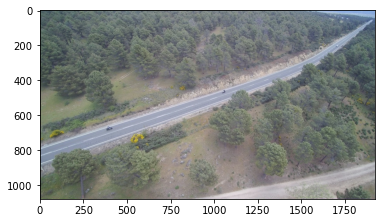

In [13]:
img_path = os.path.join(root_path, images_train[0])
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


In [17]:
image_height = 1080
image_width = 1920

#### Functions to get bounding boxes and crop images.

In [14]:
# Define a function to get bounding box information from labels.

def get_bboxes(etiketler):
    bboxes=[]
    for etiket in etiketler:
        obje_sinifi = int(etiket[0])  # Get the class ID.
        x, y, width, height = map(float, etiket[1:])  # Convert string values to float.
        x = x * image_width
        y = y * image_height
        width = width * image_width
        height = height * image_height
        bboxes.append((obje_sinifi, x, y, width, height))
    return bboxes



In [15]:
# Define a function to crop images based on bounding boxes.

def crop_images(etiketler,img):
    vehicles = []
    labels  =[]
    for label,x, y, w, h  in etiketler:
        vehicles.append(img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2) ] ) # Crop the image based on the bounding box.
        labels.append(label)
    return [vehicles,labels]

### Creating the training dataset. It involves cropping regions with vehicles (cars or motorcycles) and 10 random regions without vehicles from each image.


Motorcycles and cars

In [18]:
a = 0

for image in data.keys():  
    img_path = os.path.join(root_path, image )
    img = cv2.imread(img_path)
    bboxes = get_bboxes(data[image])
    vehicles,labels = crop_images(bboxes,img)
    for vehicle, label in zip(vehicles,labels ):
        file_n = f'{label}_cropped_{a}.png'
        if (label > 0 ):
            os.chdir("motor")
        else:
            os.chdir("car")
        
        cv2.imwrite(file_n, vehicle)
        a += 1
        os.chdir("..")
    

non-vehicles

In [19]:
# Define a function to calculate the intersection percentage between two bounding boxes.

def calculate_intersection_percentage(true_label, predicted_label):
    # Calculate intersection area
    intersection_width = min(true_label[1] + (true_label[3]) / 2, predicted_label[1] + predicted_label[3] / 2) - max(true_label[1] - (true_label[3]) / 2, predicted_label[1] - predicted_label[3] / 2)
    intersection_height = min(true_label[2] + (true_label[4])/ 2, predicted_label[2] + predicted_label[4] / 2) - max(true_label[2] - (true_label[4]) / 2, predicted_label[2] - predicted_label[4] / 2)
    if intersection_width <= 0 or intersection_height <= 0:
        return 0
    intersection_area = intersection_width * intersection_height

   
    return intersection_area

In [20]:
# Define a function to generate random frame coordinates in an image.

def generate_random_frame_coordinate(image_width, image_height,frame_width, frame_height): 
    # center pixel coordinates
    frame_center_x = frame_width // 2 
    frame_center_y = frame_height // 2 

    # x and y boundaries
    frame_left = frame_center_x 
    frame_right = image_width - frame_center_x
    frame_top = frame_center_y
    frame_bottom = image_height - frame_center_y

    # Determine random starting coordinates
    frame_x = random.randint(frame_left, frame_right)
    frame_y = random.randint(frame_top, frame_bottom)

    frame_bbox = [2,frame_x,frame_y,frame_width, frame_height] # 2 for non-vehicle class
    return frame_bbox

In [21]:
def create_bboxes_for_non_vehicles(etiketler,num,window_size):
    frame_width, frame_height = window_size
    true_labels = get_bboxes(etiketler)
    non_vehicle_frame_labels = []
    sayac = 0
    while True:
        no_intersection = True
        frame_label = generate_random_frame_coordinate(image_width, image_height,frame_width, frame_height)
        for true_label in true_labels:
            if calculate_intersection_percentage(true_label,frame_label) !=0:
               no_intersection = False
               break
        if no_intersection:
            non_vehicle_frame_labels.append(frame_label)
            sayac += 1
        if sayac >= num:
            break
    return non_vehicle_frame_labels

In [22]:
a = 0
for image in data.keys():  
    img_path = os.path.join(root_path, image )
    img = cv2.imread(img_path)
    bboxes = get_bboxes(data[image])
    non_vehicle_frame_labels = create_bboxes_for_non_vehicles(bboxes,10,[45,45])
    nones,labels = crop_images(non_vehicle_frame_labels,img)
    for none in nones:
        file_n = f'2_cropped_{a}.png'
        os.chdir("none")
        cv2.imwrite(file_n, none)
        a += 1
        os.chdir("..")



In [23]:
cars = []
motorcycles = []
non_vehicles = []

In [24]:
for dirname, _,filenames in os.walk('car'):
   cars = filenames
for dirname, _,filenames in os.walk('motor'):
   motorcycles = filenames
for dirname, _,filenames in os.walk('none'):
   non_vehicles = filenames

In [25]:
print(len(cars),len(motorcycles),len(non_vehicles))


11650 8037 36000
